In [1]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import pylab as plt
import time

# add ../mcjax to the path
import sys
sys.path.append('../../')

#from mcjax.proba.dist import Dist
from mcjax.variational.double_stochastic import DoubleStochasticVI
from mcjax.proba.neal_funnel import NealFunnel

# import variational distributions
from mcjax.proba.var_gaussian import DiagGaussian, FullCovGaussian, \
    MixtureDiagGaussian

from mcjax.util.plot_2d import evaluate_on_grid_2d, create_ellipse



In [2]:
# initialize PRNG
key = jr.key(0)

In [3]:

dist = NealFunnel()
logdensity = dist.logdensity
logdensity_batch = jax.vmap(logdensity)

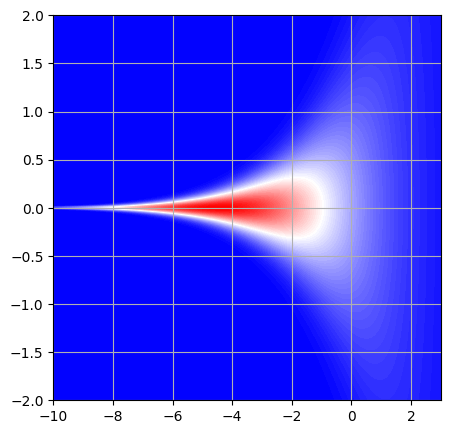

In [4]:
xmin, xmax = -10, 3
ymin, ymax = -2, 2
X, Y, Z = evaluate_on_grid_2d(
    func_batch=logdensity_batch,
    xlim=(xmin, xmax),
    ylim=(ymin, ymax),
    Nx=500,
    Ny=500
)

# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.grid()


In [5]:
# setup the variational family
dim = 2
approx_diag = DiagGaussian(dim=dim)
aprox_full = FullCovGaussian(dim=dim)
num_components = 10
approx_mixture = MixtureDiagGaussian(dim=dim, num_components=num_components)

In [6]:
# Set up VI driver
vi_diag = DoubleStochasticVI(
    logdensity=logdensity,
    approx=approx_diag,
    sticking_the_landing=True,)

vi_full = DoubleStochasticVI(
    logdensity=logdensity,
    approx=aprox_full,
    sticking_the_landing=True,)

vi_mixture = DoubleStochasticVI(
    logdensity=logdensity,
    approx=approx_mixture,
    sticking_the_landing=True,)

vi_list = [vi_diag, vi_full, vi_mixture]
vi_names = ['diag', 'full', 'mixture']

In [7]:
key, key_ = jr.split(key)
result_dict = {}

n_iter = 10_000
n_samples = 100
lr = 1e-2
for vi_engine, name in zip(vi_list, vi_names):
    print(f'Running {name} variational inference with: {n_iter} iterations, {n_samples} samples, and lr={lr}')
    # run the variational inference
    time_start = time.time()
    result = vi_engine.run(
        key=key_,
        n_iter=n_iter,
        n_samples=n_samples,
        lr=lr,
        use_jit=True,
        store_params_trace=False,
        verbose=False,)
    time_end = time.time()
    print(f'\t Elapsed time: {time_end - time_start:.2f} seconds')
    result_dict[name] = result


Running diag variational inference with: 10000 iterations, 100 samples, and lr=0.01
	 Elapsed time: 1.81 seconds
Running full variational inference with: 10000 iterations, 100 samples, and lr=0.01
	 Elapsed time: 2.04 seconds
Running mixture variational inference with: 10000 iterations, 100 samples, and lr=0.01
	 Elapsed time: 5.54 seconds


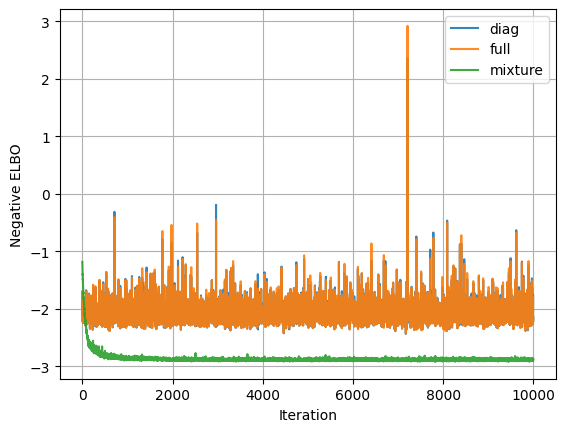

In [8]:
for name, result in result_dict.items():
    kl_trace = np.array(result['kl_trace'])
    plt.plot(kl_trace, label=name, alpha=0.9)
plt.xlabel('Iteration')
plt.ylabel('Negative ELBO')
plt.legend()
plt.grid(which="major", linestyle='-')
plt.grid(which="minor", linestyle='--', alpha=0.5)

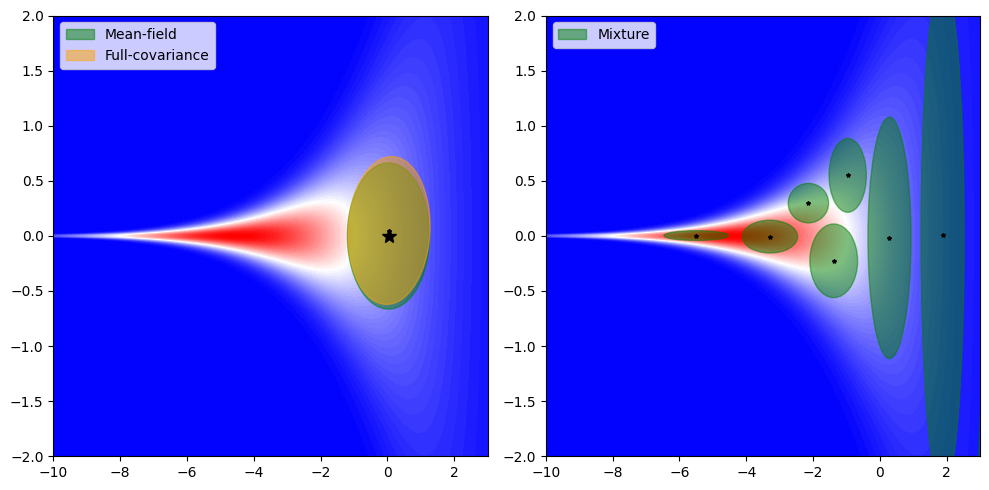

In [9]:
import matplotlib.pyplot as plt

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# left plot: mean field and full covariance
ax = axes[0]

########################
# Mean-field plot
########################
# Extract final mean-field (diag) parameters
mu_diag = result_dict["diag"]["params"]["mu"]
std_diag = result_dict["diag"]["params"]["std"]
cov_diag = jnp.diag(std_diag ** 2)

# Add Ellipse
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
ax.add_artist(create_ellipse(mu_diag, cov_diag, color='green', label='Mean-field'))
ax.plot(mu_diag[0], mu_diag[1], marker='*', color='black', markersize=10)

################
# Full covariance plot
################
# Extract final full covariance parameters
mu_full = result_dict["full"]["params"]["mu"]
cov_full = result_dict["full"]["params"]["cov"]
ax.add_artist(create_ellipse(mu_full, cov_full, color='orange', alpha=0.5, label='Full-covariance'))
ax.plot(mu_full[0], mu_full[1], marker='*', color='black', markersize=3)
ax.legend(loc="upper left")

################
# right plot: mixture
################
ax = axes[1]
# Extract final mixture parameters
mus = result_dict["mixture"]["params"]["mu"]
stds = result_dict["mixture"]["params"]["std"]
ax.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')

for k in range(num_components):
    mu = mus[k]
    std = stds[k]
    cov = jnp.diag(std ** 2)
    if k==0:
        ax.add_artist(create_ellipse(mu, cov, color='green', alpha=0.5, label='Mixture'))
    else:
        ax.add_artist(create_ellipse(mu, cov, color='green', alpha=0.5))
    ax.plot(mu[0], mu[1], marker='*', color='black', markersize=3)
# set the axis limits
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(loc="upper left")
plt.tight_layout()

In [10]:
params_mixture = result_dict["mixture"]["params_raw"]

In [11]:
# generate samples from the mixture
n_samples = 10_000
key, key_ = jr.split(key)
params_mixture = result_dict["mixture"]["params_raw"]
samples = approx_mixture.sample(
    key=key_,
    n_samples=n_samples,
    params=params_mixture,
)
samples = np.array(samples)


(-2.0, 2.0)

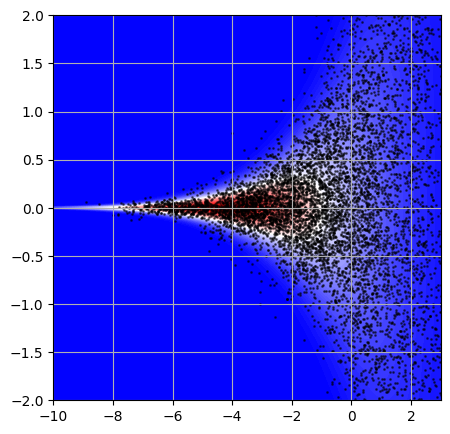

In [12]:
# plot the logpdf
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, jnp.exp(Z), 100, cmap='bwr', origin='lower')
plt.grid()

# add the samples
plt.scatter(samples[:, 0], samples[:, 1], s=1, color='black', alpha=0.5)

# set the axis limits
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)